In [149]:
import warnings
import numpy
import csep
from csep.utils import time_utils
from csep.core import binomial_evaluations as binomial
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import img_tiles
import time, datetime
from csep.core.regions import CartesianGrid2D
from csep.core.forecasts import GriddedForecast
from scipy.stats import poisson
from csep.models import EvaluationResult
import matplotlib
from csep.core import poisson_evaluations as poisson2
from csep.utils.stats import get_Kagan_I1_score
from csep.core.binomial_evaluations import binary_joint_log_likelihood_ndarray as jolib
from csep.core.poisson_evaluations import poisson_joint_log_likelihood_ndarray as jolip
import scipy
import logging


In [150]:
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

# Suppress findfont warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [151]:
start_date = time_utils.strptime_to_utc_datetime('2014-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2022-01-01 00:00:00.0')
duration = (end_date - start_date) # in days
duration =  round(duration.days / 365.25,2) # in years
ofp = 5.0 # original forecast period (in years)
factor = duration / ofp # scaling factor
seed = 123456

In [152]:
mw_min = 4.95
mw_max = 8.95
dmw = 0.1
mws = np.arange(mw_min, mw_max+dmw/2, dmw)

#### Adjust the file paths of the following:

In [153]:
GEAR1NZ_fname = '../data/GEAR1495_NZ.dat'
areaNZ_fname = '../data/GEAR1a_NZ.dat'

In [154]:
NZHM_fname = '../data/NZHM_5year_rates-fromXML.dat'
PPE_fname = '../data/nz5yrppe_c.dat'
SUP_fname = '../data/nz5yrsup_c.dat'

In [155]:
def read_GEAR1_format(filename, area_filename, magnitudes):
    """filename"""
    # long, lat, >=4.95, >=5.0, ..., >= 8.95
    t0 = time.time()
    bulk_data = np.loadtxt(filename, skiprows=1, delimiter=',')
    
    # construction region information
    lons = bulk_data[:,1]
    lats = bulk_data[:,2]
    coords = np.column_stack([lons, lats])
    
    # coordinates are given as midpoints origin should be in the 'lower left' corner
    r = CartesianGrid2D.from_origins(coords, magnitudes=magnitudes)
    
    # shape: (num_space_bins, num_mag_bins)
    bulk_data_no_coords = bulk_data[:, 3:]
    
    # tono's format provides cumulative rates per meter**2
    incremental_yrly_density = np.diff(np.fliplr(bulk_data_no_coords))
    
    # computing the differences, but returning array with the same shape
    incremental_yrly_density = np.column_stack([np.fliplr(incremental_yrly_density), bulk_data_no_coords[:,-1]])
    
    # read in area to denormalize back onto csep grid
    area = np.loadtxt(area_filename, skiprows=1, delimiter=',')

    # allows us to use broadcasting
    m2_per_cell = np.reshape(area[:,-1], (len(area[:,1]), 1))
    incremental_yrly_rates = incremental_yrly_density * m2_per_cell
    
    return incremental_yrly_rates, r, magnitudes

In [156]:
GEAR1NZ_f = GriddedForecast.from_custom(read_GEAR1_format, name='GEAR1', func_args=(GEAR1NZ_fname, areaNZ_fname, mws)).scale(factor)
NZHM_f = csep.load_gridded_forecast(NZHM_fname, start_date=start_date, end_date=end_date, name='NZHM').scale(factor)
PPE_f = csep.load_gridded_forecast(PPE_fname, start_date=start_date, end_date=end_date, name='PPE').scale(factor)
SUP_f = csep.load_gridded_forecast(SUP_fname, start_date=start_date, end_date=end_date, name='SUP').scale(factor)

#### Adjust this file path, too.

In [157]:
GeoNet = '../data/GeoNet_catalog2021.txt'

In [158]:
bulk_data = np.loadtxt(GeoNet, skiprows=1, delimiter='\t', dtype='str')
idx = bulk_data[:,0]
bulk_time = bulk_data[:,1]
latitude = bulk_data[:,2].astype(float)
longitude = bulk_data[:,3].astype(float)
depth = bulk_data[:,13].astype(float)
magnitude = bulk_data[:,11].astype(float)

In [159]:
origin_time = []

for i in range(len(bulk_time)):
    origin_time.append(int(bulk_time[i]))

In [160]:
dt = []
for i in range (len(origin_time)):
    dt.append(datetime.datetime.strptime(str(origin_time[i]),'%Y%m%d%H%M%S'))

In [161]:
dt2 = []

for i in range (len(dt)):
    dt2.append(time_utils.strptime_to_utc_epoch(str(dt[i])))

In [162]:
eventlist = np.column_stack([idx, dt2, latitude, longitude, depth, magnitude])
array_of_tuples = map(tuple, eventlist)
tuple_of_tuples = tuple(array_of_tuples)

In [163]:
start_date = time_utils.strptime_to_utc_epoch('2014-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_epoch('2022-01-01 00:00:00.0')

#### NOTE: These are the same catalog, but are defined in slightly different New Zealand testing regions. It is important to take this into account when conducting the binary s-test (the number of cells between forecasts and catalog must be the same).

In [164]:
catalogue_NZG = csep.catalogs.CSEPCatalog(data=tuple_of_tuples)
catalogue_NZG.filter(f'origin_time >= {start_date}')
catalogue_NZG.filter(f'origin_time < {end_date}')
catalogue_NZG.filter('magnitude >= 4.95')
catalogue_NZG.filter('depth < 40.0')
catalogue_NZG.filter_spatial(region=GEAR1NZ_f.region, update_stats=False, in_place=True)

In [165]:
catalogue_NZ = csep.catalogs.CSEPCatalog(data=tuple_of_tuples)

In [166]:
catalogue_NZ.filter(f'origin_time >= {start_date}')
catalogue_NZ.filter(f'origin_time < {end_date}')
catalogue_NZ.filter('magnitude >= 4.95')
catalogue_NZ.filter('depth < 40.0')
catalogue_NZ.filter_spatial(region=NZHM_f.region, update_stats=False, in_place=True)

In [167]:
catalog_NZHM = csep.catalogs.CSEPCatalog(data=tuple_of_tuples)

In [168]:
catalog_NZHM.filter(f'origin_time >= {start_date}')
catalog_NZHM.filter(f'origin_time < {end_date}')
catalog_NZHM.filter('magnitude >= 4.95')
catalog_NZHM.filter('depth < 40.0')
catalog_NZHM.filter_spatial(region=PPE_f.region, update_stats=False, in_place=True)

In [169]:
catalogue_NZP = csep.catalogs.CSEPCatalog(data=tuple_of_tuples)

In [170]:
catalogue_NZP.filter(f'origin_time >= {start_date}')
catalogue_NZP.filter(f'origin_time < {end_date}')
catalogue_NZP.filter('magnitude >= 4.95')
catalogue_NZP.filter('depth < 40.0')
catalogue_NZP.filter_spatial(region=PPE_f.region, update_stats=False, in_place=True)

#### This is the calculated 8-year earthquake-rate variance for New Zealand (see Bayona et al., 2023).

In [171]:
rates = pd.read_csv('../data/BND_database1942_8yr.txt', sep='\t', skiprows=0)

In [172]:
var_GeoNet = rates.EQs.var()

In [173]:
def _get_marker_style(obs_stat, p, one_sided_lower):
    """Returns matplotlib marker style as fmt string"""
    if obs_stat < p[0] or obs_stat > p[1]:
        # red circle
        fmt = 'ko'
    else:
        # green square
        fmt = 'ko'
    if one_sided_lower:
        if obs_stat < p[0]:
            fmt = 'ko'
        else:
            fmt = 'ko'
    return fmt

In [174]:
def _get_axis_limits(pnts, border=0.05):
    """Returns a tuple of x_min and x_max given points on plot."""
    x_min = numpy.min(pnts)
    x_max = numpy.max(pnts)
    xd = (x_max - x_min)*border
    return (x_min-xd, x_max+xd)

In [175]:
def plot_consistency_test(eval_results, n_models, normalize=False, one_sided_lower=True, plot_args=None, variance=None):
    """ Plots results from CSEP1 tests following the CSEP1 convention.
    Note: All of the evaluations should be from the same type of evaluation, otherwise the results will not be
          comparable on the same figure.
    Args:
        eval_results (list): Contains the tests results :class:`csep.core.evaluations.EvaluationResult` (see note above)
        normalize (bool): select this if the forecast likelihood should be normalized by the observed likelihood. useful
                          for plotting simulation based simulation tests.
        one_sided_lower (bool): select this if the plot should be for a one sided test
        plot_args(dict): optional argument containing a dictionary of plotting arguments, with keys as strings and items as described below
    Optional plotting arguments:
        * figsize: (:class:`list`/:class:`tuple`) - default: [6.4, 4.8]
        * title: (:class:`str`) - default: name of the first evaluation result type
        * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 10
        * xlabel: (:class:`str`) - default: 'X'
        * xlabel_fontsize: (:class:`float`) - default: 10
        * xticks_fontsize: (:class:`float`) - default: 10
        * ylabel_fontsize: (:class:`float`) - default: 10
        * color: (:class:`float`/:class:`None`) If None, sets it to red/green according to :func:`_get_marker_style` - default: 'black'
        * linewidth: (:class:`float`) - default: 1.5
        * capsize: (:class:`float`) - default: 4
        * hbars:  (:class:`bool`)  Flag to draw horizontal bars for each model - default: True
        * tight_layout: (:class:`bool`) Set matplotlib.figure.tight_layout to remove excess blank space in the plot - default: True
    Returns:
        ax (:class:`matplotlib.pyplot.axes` object)
    """


    try:
        results = list(eval_results)
    except TypeError:
        results = [eval_results]
    results.reverse()
    # Parse plot arguments. More can be added here
    if plot_args is None:
        plot_args = {}
    figsize= plot_args.get('figsize', (7,8))
    xlabel = plot_args.get('xlabel', 'X')
    xlabel_fontsize = plot_args.get('xlabel_fontsize', None)
    xticks_fontsize = plot_args.get('xticks_fontsize', None)
    ylabel_fontsize = plot_args.get('ylabel_fontsize', None)
    color = plot_args.get('color', 'black')
    linewidth = plot_args.get('linewidth', None)
    capsize = plot_args.get('capsize', 4)
    hbars = plot_args.get('hbars', True)
    tight_layout = plot_args.get('tight_layout', True)
    percentile = plot_args.get('percentile', 95)

    fig, ax = plt.subplots(figsize=(6, n_models))
    #fig, ax = pyplot.subplots(figsize=figsize)
    xlims = []

    for index, res in enumerate(results):
        # handle analytical distributions first, they are all in the form ['name', parameters].
        if res.test_distribution[0] == 'poisson':
            plow = scipy.stats.poisson.ppf((1 - percentile/100.)/2., res.test_distribution[1])
            phigh = scipy.stats.poisson.ppf(1 - (1 - percentile/100.)/2., res.test_distribution[1])
            observed_statistic = res.observed_statistic

        elif res.test_distribution[0] == 'negative_binomial':
            var = variance
            observed_statistic = res.observed_statistic
            mean = res.test_distribution[1]
            upsilon = 1.0 - ((var - mean) / var)
            tau = (mean**2 /(var - mean))
            phigh = scipy.stats.nbinom.ppf((1 - percentile/100.)/2., tau, upsilon)
            plow = scipy.stats.nbinom.ppf(1 - (1 - percentile/100.)/2., tau, upsilon)

        # empirical distributions
        else:
            if normalize:
                test_distribution = numpy.array(res.test_distribution) - res.observed_statistic
                observed_statistic = 0
            else:
                test_distribution = numpy.array(res.test_distribution)
                observed_statistic = res.observed_statistic
            # compute distribution depending on type of test
            if one_sided_lower:
                plow = numpy.percentile(test_distribution, 5)
                phigh = numpy.percentile(test_distribution, 100)
            else:
                plow = numpy.percentile(test_distribution, 2.5)
                phigh = numpy.percentile(test_distribution, 97.5)

        if not numpy.isinf(observed_statistic): # Check if test result does not diverge
            low = observed_statistic - plow
            high = phigh - observed_statistic
            plt.hlines(y=index, xmin=plow, xmax=phigh, colors='k', lw=2, alpha=0.8)
            #ax.errorbar(observed_statistic, index, xerr=numpy.array([[np.abs(low), np.abs(high)]]).T,
             #           fmt=_get_marker_style(observed_statistic, (plow, phigh), one_sided_lower),
              #          capsize=4, linewidth=linewidth, ecolor=color, markersize = 10, zorder=1)
            # determine the limits to use
            xlims.append((plow, phigh, observed_statistic))
            # we want to only extent the distribution where it falls outside of it in the acceptable tail
            if one_sided_lower:
                if observed_statistic >= plow and phigh < observed_statistic:
                    # draw dashed line to infinity
                    xt = numpy.linspace(phigh, 99999, 100)
                    yt = numpy.ones(100) * index
                    ax.plot(xt, yt, linestyle='--', linewidth=linewidth, color=color)

        else:
            print('Observed statistic diverges for forecast %s, index %i.'
                  ' Check for zero-valued bins within the forecast'% (res.sim_name, index))
            ax.barh(index, 99999, left=-10000, height=1, color=['red'], alpha=0.5)


    try:
        ax.set_xlim(*_get_axis_limits(xlims))
    except ValueError:
        raise ValueError('All EvaluationResults have infinite observed_statistics')
    ax.set_yticks(numpy.arange(len(results)))
    ax.set_yticklabels([res.sim_name for res in results], fontsize=15)
    ax.set_ylim([-0.5, len(results)-0.5])
    if hbars:
        yTickPos = ax.get_yticks()
        if len(yTickPos) >= 2:
            ax.barh(yTickPos, numpy.array([99999] * len(yTickPos)), left=-10000,
                    height=(yTickPos[1] - yTickPos[0]), color=['w', 'orangered'], alpha=0.2, zorder=0)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    if tight_layout:
        ax.figure.tight_layout()
        fig.tight_layout()
    return ax

In [176]:
def plot_pvalues_and_intervals(test_results, ax, var=None, pos_bar=False, show_bar=False):
    """ Plots p-values and intervals for a list of Poisson or NBD test results
    Args:
        test_results (list): list of EvaluationResults for N-test. All tests should use the same distribution
                             (ie Poisson or NBD).
        ax (matplotlib.axes.Axes.axis): axes to use for plot. create using matplotlib
        var (float): variance of the NBD distribution. Must be used for NBD plots.
    Returns:
        ax (matplotlib.axes.Axes.axis): axes handle containing this plot
    Raises:
        ValueError: throws error if NBD tests are supplied without a variance
    """

    variance = var
    percentile = 97.5
    p_values = []

    # Differentiate between N-tests and other consistency tests
    
    if test_results[0].name == 'NBD N-Test' or test_results[0].name == 'Poisson N-Test':
        legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='red', lw=0, label=r'p < 10e-5', markersize=15, markeredgecolor='k'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='#FF7F50', lw=0, label=r'10e-5 $\leq$ p < 10e-4', markersize=15, markeredgecolor='k'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='gold', lw=0, label=r'10e-4 $\leq$ p < 10e-3', markersize=15, markeredgecolor='k'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='white', lw=0, label=r'10e-3 $\leq$ p < 0.0125', markersize=15, markeredgecolor='k'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='skyblue', lw=0, label=r'0.0125 $\leq$ p < 0.025', markersize=15, markeredgecolor='k'),
                           matplotlib.lines.Line2D([0], [0], marker='o', color='blue', lw=0, label=r'p $\geq$ 0.025', markersize=15, markeredgecolor='k')]
        
        if show_bar==True: 
            ax.legend(handles=legend_elements, loc=pos_bar, fontsize=13, edgecolor='k') 
    
  
        # Act on Negative binomial tests
        if test_results[0].name == 'NBD N-Test':
            if var is None:
                raise ValueError("var must not be None if N-tests use the NBD distribution.")

            for i in range(len(test_results)):
                mean = test_results[i].test_distribution[1]
                upsilon = 1.0 - ((variance - mean) / variance)
                tau = (mean**2 /(variance - mean))
                phigh97 = scipy.stats.nbinom.ppf((1 - percentile/100.)/2., tau, upsilon)
                plow97 = scipy.stats.nbinom.ppf(1 - (1 - percentile/100.)/2., tau, upsilon)
                low97 = test_results[i].observed_statistic - plow97
                high97 = phigh97 - test_results[i].observed_statistic
                plt.hlines(y=(len(test_results)-1) - i, xmin=plow97, xmax=phigh97, colors='k', lw=2, alpha=0.5,
                          linestyles='dotted')
                #ax.errorbar(test_results[i].observed_statistic, (len(test_results)-1) - i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                #            color='slategray', alpha=1.0, zorder=0)
                p_values.append(min(test_results[i].quantile) * 2.0) # Calculated p-values according to Meletti et al., (2021)

                if p_values[i] < 10e-5:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='red', markersize=15, markeredgecolor='k', zorder=2)
                if p_values[i] >= 10e-5 and p_values[i] < 10e-4:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='#FF7F50', markersize=15, markeredgecolor='k', zorder=2)
                if p_values[i] >= 10e-4 and p_values[i] < 10e-3:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='gold', markersize=15, markeredgecolor='k', zorder=2)
                if p_values[i] >= 10e-3 and p_values[i] < 0.0125:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='white', markersize=15, markeredgecolor='k', zorder=2)
                if p_values[i] >= 0.0125 and p_values[i] < 0.025:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='skyblue', markersize=15, markeredgecolor='k', zorder=2)
                if p_values[i] >= 0.025:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='blue', markersize=15, markeredgecolor='k', zorder=2)
        
        # Act on Poisson N-test
        if test_results[0].name == 'Poisson N-Test':
            for i in range(len(test_results)):
                plow97 = scipy.stats.poisson.ppf((1 - percentile/100.)/2., test_results[i].test_distribution[1])
                phigh97 = scipy.stats.poisson.ppf(1 - (1 - percentile/100.)/2., test_results[i].test_distribution[1])
                low97 = test_results[i].observed_statistic - plow97
                high97 = phigh97 - test_results[i].observed_statistic
                plt.hlines(y=(len(test_results)-1) - i, xmin=plow97, xmax=phigh97, colors='grey', lw=2, alpha=0.5,
                          linestyles='dotted')
                #ax.errorbar(test_results[i].observed_statistic, (len(test_results)-1) - i, xerr=numpy.array([[np.abs(low97), np.abs(high97)]]).T, capsize=4, 
                 #           color='slategray', alpha=1.0, zorder=0)
                p_values.append(min(test_results[i].quantile) * 2.0)
                if p_values[i] < 10e-5:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='red', markersize=15, markeredgecolor='k', zorder=2)
                elif p_values[i] >= 10e-5 and p_values[i] < 10e-4:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='#FF7F50', markersize=15, markeredgecolor='k', zorder=2)
                elif p_values[i] >= 10e-4 and p_values[i] < 10e-3:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='gold', markersize=15, markeredgecolor='k', zorder=2)
                elif p_values[i] >= 10e-3 and p_values[i] < 0.0125:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='white', markersize=15, markeredgecolor='k', zorder=2)
                elif p_values[i] >= 0.0125 and p_values[i] < 0.025:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='skyblue', markersize=15, markeredgecolor='k', zorder=2)
                elif p_values[i] >= 0.025:
                    ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='blue', markersize=15, markeredgecolor='k', zorder=2)
    
    # Operate on all other consistency tests
    else:
        for i in range(len(test_results)):
            plow97 = numpy.percentile(test_results[i].test_distribution, 2.5)
            phigh97 = numpy.percentile(test_results[i].test_distribution, 100)
            low97 = test_results[i].observed_statistic - plow97
            high97 = phigh97 - test_results[i].observed_statistic  
            plt.hlines(y=(len(test_results)-1) -i, xmin=plow97, xmax=phigh97, colors='k', lw=2, alpha=0.5,
                      linestyles='dotted')
            #ax.errorbar(test_results[i].observed_statistic, (len(test_results)-1) -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
             #           color='slategray', alpha=1.0, zorder=0)
            p_values.append(test_results[i].quantile)

            if p_values[i] < 10e-5:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='red', markersize=15, markeredgecolor='k', zorder=2)
            elif p_values[i] >= 10e-5 and p_values[i] < 10e-4:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='#FF7F50', markersize=15, markeredgecolor='k', zorder=2)
            elif p_values[i] >= 10e-4 and p_values[i] < 10e-3:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='gold', markersize=15, markeredgecolor='k', zorder=2)
            elif p_values[i] >= 10e-3  and p_values[i] < 0.025:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='white', markersize=15, markeredgecolor='k', zorder=2)
            elif p_values[i] >= 0.025 and p_values[i] < 0.05:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='skyblue', markersize=15, markeredgecolor='k', zorder=2)
            elif p_values[i] >= 0.05:
                ax.plot(test_results[i].observed_statistic, (len(test_results)-1) - i, marker='o', color='blue', markersize=15, markeredgecolor='k', zorder=2)
     
        if show_bar==True:   
        
            legend_elements = [
            matplotlib.lines.Line2D([0], [0], marker='o', color='red', lw=0, label=r'p < 10e-5', markersize=15, markeredgecolor='k'),
            matplotlib.lines.Line2D([0], [0], marker='o', color='#FF7F50', lw=0, label=r'10e-5 $\leq$ p < 10e-4', markersize=15, markeredgecolor='k'),
            matplotlib.lines.Line2D([0], [0], marker='o', color='gold', lw=0, label=r'10e-4 $\leq$ p < 10e-3', markersize=15, markeredgecolor='k'),
            matplotlib.lines.Line2D([0], [0], marker='o', color='white', lw=0, label=r'10e-3 $\leq$ p < 0.025', markersize=15, markeredgecolor='k'),
            matplotlib.lines.Line2D([0], [0], marker='o', color='skyblue', lw=0, label=r'0.025 $\leq$ p < 0.05', markersize=15, markeredgecolor='k'),
            matplotlib.lines.Line2D([0], [0], marker='o', color='blue', lw=0, label=r'p $\geq$ 0.05', markersize=15, markeredgecolor='k')]

            ax.legend(handles=legend_elements, loc=pos_bar, fontsize=13, edgecolor='k') 

    return ax

In [177]:
nbntest_GEAR1NZ = binomial.negative_binomial_number_test(GEAR1NZ_f, catalogue_NZ, var_GeoNet)
nbntest_NZHM = binomial.negative_binomial_number_test(NZHM_f, catalogue_NZ, var_GeoNet)
nbntest_PPE = binomial.negative_binomial_number_test(PPE_f, catalogue_NZP, var_GeoNet)
nbntest_SUP = binomial.negative_binomial_number_test(SUP_f, catalogue_NZP, var_GeoNet)

In [178]:
bstest_GEAR1NZ = binomial.binary_spatial_test(GEAR1NZ_f, catalogue_NZ, seed=seed)
bstest_NZHM = binomial.binary_spatial_test(NZHM_f, catalogue_NZ, seed=seed)
bstest_PPE = binomial.binary_spatial_test(PPE_f, catalogue_NZP, seed=seed)
bstest_SUP = binomial.binary_spatial_test(SUP_f, catalogue_NZP, seed=seed)

<Figure size 640x480 with 0 Axes>

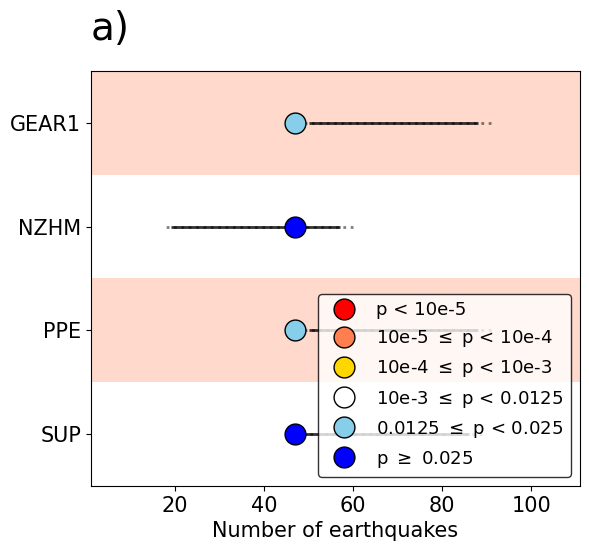

In [179]:
plt.figure()

nbd_Ntests_NZ = [nbntest_GEAR1NZ, nbntest_NZHM, nbntest_PPE, nbntest_SUP]

ax = plot_consistency_test(nbd_Ntests_NZ, n_models=5, one_sided_lower=False, variance=var_GeoNet, plot_args={'xlabel': 'Number of earthquakes',
                                                                                                              'ylabel_fontsize': 13})

ax = plot_pvalues_and_intervals(nbd_Ntests_NZ, ax, var=var_GeoNet, pos_bar=4, show_bar=True)


ax.text(1, 3.8, 'a)', fontsize=28, color='black')
ax.set_xlim(1,111)
ax.set_title('')
plt.savefig('../output/figure4a.png', dpi=150, bbox_inches = 'tight')

<Figure size 640x480 with 0 Axes>

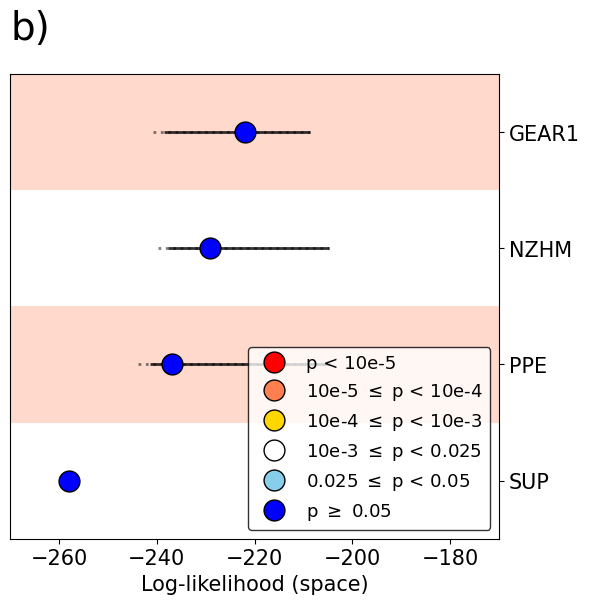

In [180]:
fig = plt.figure()

sbtests_NZ = [bstest_GEAR1NZ, bstest_NZHM, bstest_PPE, bstest_SUP]

ax_bstest = plot_consistency_test(sbtests_NZ, n_models=5.5, one_sided_lower=True, plot_args={'xlabel': 'Log-likelihood (space)'})

ax_bstest = plot_pvalues_and_intervals(sbtests_NZ, ax_bstest, pos_bar=4, show_bar=True)

ax_bstest.text(-270, 3.8, 'b)', fontsize =28, color='black')
ax_bstest.set_xlim(-270,-170)
ax_bstest.yaxis.tick_right()
ax_bstest.set_title('')

plt.savefig('../output/figure4b.png', dpi=150, bbox_inches = 'tight')

In [181]:
def plot_ROC(forecasts, catalogs, axes=None, plot_uniform=True, savepdf=True,
             savepng=True, show=True,
             plot_args=None):
    """
    Plot Receiver operating characteristic (ROC) Curves based on forecast and test catalog.

    The ROC is computed following this procedure:
        (1) Obtain spatial rates from GriddedForecast
        (2) Rank the rates in descending order (highest rates first).
        (3) Sort forecasted rates by ordering found in (2), and normalize rates so the cumulative sum equals unity.
        (4) Obtain binned spatial rates from observed catalog
        (5) Sort gridded observed rates by ordering found in (2), and normalize so the cumulative sum equals unity.
        (6) Compute spatial bin areas, sort by ordering found in (2), and normalize so the cumulative sum equals unity.
        (7) Plot ordered and cumulated rates (forecast and catalog) against ordered and cumulated bin areas.

    Note that:
        (1) The testing catalog and forecast should have exactly the same time-window (duration)
        (2) Forecasts should be defined over the same region
        (3) If calling this function multiple times, update the color in plot_args

    Args:
        forecast (:class: `csep.forecast.GriddedForecast`):
        catalog (:class:`AbstractBaseCatalog`): evaluation catalog
        axes (:class:`matplotlib.pyplot.ax`): Previously defined ax object
        savepdf (str):    output option of pdf file
        savepng (str):    output option of png file
        plot_uniform (bool): if true, include uniform forecast on plot

        Optional plotting arguments:
            * figsize: (:class:`list`/:class:`tuple`) - default: [9, 8]
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * forecast_linestyle: (:class:`str`) - default: '-'
            * observed_linecolor: (:class:`str`) - default: 'blue'
            * observed_linestyle: (:class:`str`) - default: '-'
            * forecast_label: (:class:`str`) - default: Observed (Forecast)
            * legend_fontsize: (:class:`float`) Fontsize of the plot title - default: 16
            * legend_loc: (:class:`str`) - default: 'upper left'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * label_fontsize: (:class:`float`) Fontsize of the plot title - default: 14
            * title: (:class:`str`) - default: 'ROC Curve'
            * filename: (:class:`str`) - default: roc_curve.

    Returns:
        :class:`matplotlib.pyplot.ax` object

    Raises:
        TypeError: throws error if CatalogForecast-like object is provided
        RuntimeError: throws error if Catalog and Forecast do not have the same region

        Written by Han Bao, UCLA, March 2021. Modified June 2021.
    """
#     if not catalog.region == forecasts.region:
#         raise RuntimeError(
#             "catalog region and forecast region must be identical.")

    # Parse plotting arguments
    plot_args = plot_args or {}
    figsize = plot_args.get('figsize', (9, 8))
    #forecast_linecolor = plot_args.get('forecast_linecolor', ['red', 'gold', 'purple'])
    forecast_linestyle = plot_args.get('forecast_linestyle', '-')
    observed_linecolor = plot_args.get('observed_linecolor', '#e41a1c')
    observed_linestyle = plot_args.get('observed_linestyle', '-')
    legend_fontsize = plot_args.get('legend_fontsize', 16)
    legend_loc = plot_args.get('legend_loc', 'upper left')
    title_fontsize = plot_args.get('title_fontsize', 16)
    label_fontsize = plot_args.get('label_fontsize', 18)
    filename = plot_args.get('filename', 'roc_figure')
    title = plot_args.get('title', '')

    #observed_label = plot_args.get('observed_label', f'Observed {name}')
    
    # This part could be vectorized if optimizations become necessary
    # Initialize array to store cell area in km^2
    
    observed_label = plot_args.get('observed_label', f'Observed catalog')  
    
    # Initialize figure
    if axes is not None:
        ax = axes
    else:
        #fig, ax = pyplot.subplots(figsize=figsize)
        fig, ax = plt.subplots(figsize=figsize)
        #ax.set_xti
    
    for i in range(len(forecasts)):
        if forecasts[i].name == 'GEAR1' or forecasts[i].name == 'NZHM':
            
            obs_counts = catalogs[0].spatial_counts()
            
        
        else:
            obs_counts = catalogs[1].spatial_counts()

    # Plot catalog ordered by forecast rates
    
            
        #if not catalog.region == forecasts[i].region:
         #   raise RuntimeError(
          #      "catalog region and forecast region must be identical.")
        
        name = forecasts[i].name
        if not name:
            name = ''
        else:
            name = f'{name}'

        forecast_label = plot_args.get('forecast_label', f'{name}')
        

#     # Initialize figure
#     if axes is not None:
#         ax = axes
#     else:
#         fig, ax = pyplot.subplots(figsize=figsize)

    # This part could be vectorized if optimizations become necessary
    # Initialize array to store cell area in km^2
#     area_km2 = catalog.region.get_cell_area()
#     obs_counts = catalog.spatial_counts()

    # Obtain rates (or counts) aggregated in spatial cells
    # If CatalogForecast, needs expected rates. Might take some time to compute.
        rate = forecasts[i].spatial_counts()

    # Get index of rates (descending sort)
        I = numpy.argsort(rate)
        I = numpy.flip(I)

#     # Order forecast and cells rates by highest rate cells first
        fore_norm_sorted = numpy.cumsum(rate[I]) / numpy.sum(rate)
        area_km2 = forecasts[i].region.get_cell_area()
        area_norm_sorted = numpy.cumsum(area_km2[I]) / numpy.sum(area_km2)

#     # Compute normalized and sorted rates of observations
        obs_norm_sorted = numpy.cumsum(obs_counts[I]) / numpy.sum(obs_counts)   
        
        forecast_linecolor= ['#377eb8', '#4daf4a', '#984ea3']
        # Plot sorted and normalized forecast (descending order)
        ax.step(area_norm_sorted, fore_norm_sorted,
            label=forecast_label,
            color=forecast_linecolor[i],
            linestyle=forecast_linestyle)

        
    
    # Plot uniform forecast
    if plot_uniform:
            ax.plot(area_norm_sorted, area_norm_sorted, '#ff7f00', label='SUP')
    # Plot cell-wise rates of observed catalog ordered by forecast rates (descending order)
    ax.step(area_norm_sorted, obs_norm_sorted,
            label=observed_label,
            color=observed_linecolor,
            linestyle=observed_linestyle)
    
    
    ax.legend(loc=legend_loc, shadow=True, fontsize=legend_fontsize) 
    
    # Plotting arguments
    ax.set_ylabel("True Positive Rate", fontsize=label_fontsize)
    ax.set_xlabel('False Positive Rate (Normalized Area)',
                  fontsize=label_fontsize)
    ax.set_xscale('log')
    ax.set_yscale('linear')
    #ax.legend(loc=legend_loc, shadow=True, fontsize=legend_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.text(1e-4, 1.1, 'b)', fontsize=28, color='black')
    # ax.set_xticklabels(ax.get_yticks(), fontsize=15)
    # ax.set_yticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=15)
    
    if filename:
        if savepdf:
            outFile = "{}.pdf".format(filename)
            plt.savefig(outFile, format='pdf')
        if savepng:
            outFile = "{}.png".format(filename)
            plt.savefig(outFile, format='png', dpi=150, bbox_inches = 'tight')  
    #ax.set_xlim(-0.2,1.2)
    if show:
        plt.show()
    
    return ax

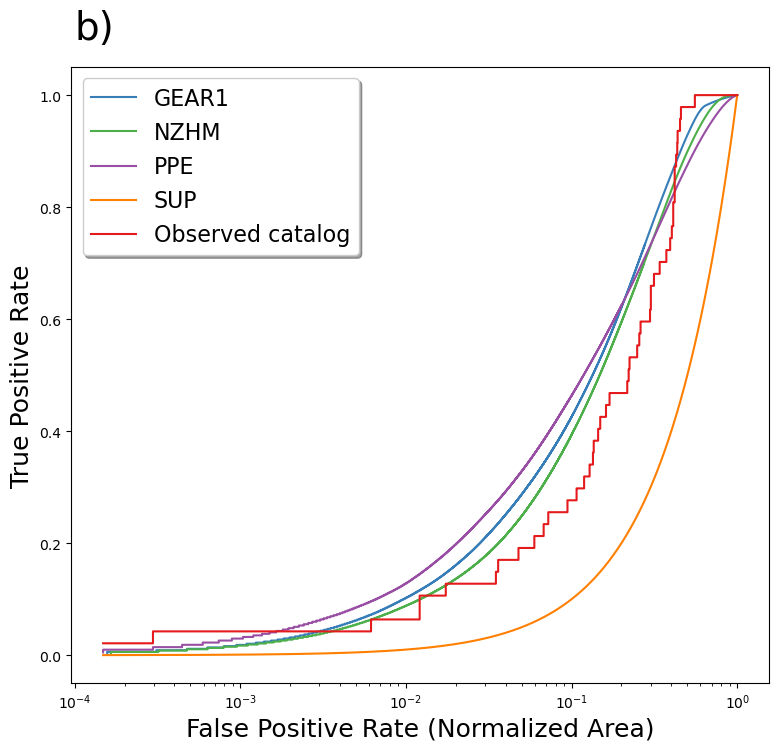

In [182]:
args_dict = {
             'bbox_inches' : 'tight',
             'tight_layout': True,
             'filename' : "../output/figure6b"
            }

ax = plot_ROC([GEAR1NZ_f, NZHM_f, PPE_f], [catalogue_NZ, catalogue_NZP], axes=None, plot_uniform=True, savepdf=False,
             savepng=True, show=True,
             plot_args=args_dict)

# plt.savefig('../output/roc_curves.png', dpi=150, bbox_inches = 'tight')

In [183]:
KaganI1_GEAR1 = get_Kagan_I1_score(GEAR1NZ_f, catalogue_NZG)
KaganI1_NZHM = get_Kagan_I1_score(NZHM_f, catalogue_NZ)
KaganI1_PPE = get_Kagan_I1_score(PPE_f, catalogue_NZP)
KaganI1_SUP = get_Kagan_I1_score(SUP_f, catalogue_NZP)

In [184]:
KaganI1_GEAR1, KaganI1_NZHM, KaganI1_PPE, KaganI1_SUP

(array([1.26997472]),
 array([0.87949199]),
 array([0.67241692]),
 array([1.45966974e-05]))

In [185]:
target_idx_NZG = numpy.nonzero(catalogue_NZG.spatial_counts().ravel())
target_rates_GEAR1 = numpy.log(GEAR1NZ_f.spatial_counts().ravel()[target_idx_NZG])

target_idx_NZ = numpy.nonzero(catalogue_NZ.spatial_counts().ravel())
target_rates_NZHM = numpy.log(NZHM_f.spatial_counts().ravel()[target_idx_NZ])

target_idx_NZP = numpy.nonzero(catalogue_NZP.spatial_counts().ravel())
target_rates_PPE = numpy.log(PPE_f.spatial_counts().ravel()[target_idx_NZP])
target_rates_SUP = numpy.log(SUP_f.spatial_counts().ravel()[target_idx_NZP])

LLP_GEAR1 = jolip(target_rates_GEAR1, catalogue_NZG.event_count, GEAR1NZ_f.event_count)
LLP_NZHM = jolip(target_rates_NZHM, catalogue_NZ.event_count, NZHM_f.event_count)
LLP_PPE = jolip(target_rates_PPE, catalogue_NZP.event_count, PPE_f.event_count)
LLP_SUP = jolip(target_rates_SUP, catalogue_NZP.event_count, SUP_f.event_count)

In [186]:
LLP_GEAR1, LLP_NZHM, LLP_PPE, LLP_SUP

(-359.5437039844528,
 -366.3012461524382,
 -374.4636048003642,
 -394.94378363955553)

In [187]:
LLB_GEAR1 = jolib(GEAR1NZ_f.spatial_counts(), catalogue_NZG.spatial_counts())
LLB_NZHM = jolib(NZHM_f.spatial_counts(), catalogue_NZ.spatial_counts())
LLB_PPE = jolib(PPE_f.spatial_counts(), catalogue_NZP.spatial_counts())
LLB_SUP = jolib(SUP_f.spatial_counts(), catalogue_NZP.spatial_counts())

In [188]:
LLB_GEAR1, LLB_NZHM, LLB_PPE, LLB_SUP

(-222.00952211810855,
 -229.21953552306914,
 -236.90847053458322,
 -257.92161391930955)

In [189]:
def _brier_score_ndarray(forecast, observations):
    """ Computes the brier (binary) score for spatial-magnitude cells
    using the formula:
    Q(Lambda, Sigma) = 1/N sum_{i=1}^N (Lambda_i - Ind(Sigma_i > 0 ))^2
    where Lambda is the forecast array, Sigma is the observed catalog, N the
    number of spatial-magnitude cells and Ind is the indicator function, which
    is 1 if Sigma_i > 0 and 0 otherwise.
    Args:
        forecast: 2d array of forecasted rates
        observations: 2d array of observed counts
    Returns
        brier: float, brier score
    """

    prob_success = 1 - poisson.cdf(0, forecast)
    brier_cell = np.square(prob_success.ravel() - (observations.ravel() > 0))
    brier = -2 * brier_cell.sum()

    for n_dim in observations.shape:
        brier /= n_dim
    return brier

In [190]:
Brier_GEAR1 = _brier_score_ndarray(GEAR1NZ_f.spatial_counts(), catalogue_NZG.spatial_counts())
Brier_NZHM = _brier_score_ndarray(NZHM_f.spatial_counts(), catalogue_NZ.spatial_counts())
Brier_PPE = _brier_score_ndarray(PPE_f.spatial_counts(), catalogue_NZP.spatial_counts())
Brier_SUP = _brier_score_ndarray(SUP_f.spatial_counts(), catalogue_NZP.spatial_counts())

In [191]:
Brier_GEAR1, Brier_NZHM, Brier_PPE, Brier_SUP

(-0.013026954038539956,
 -0.013063785498306628,
 -0.013179259306498999,
 -0.013183936162493878)

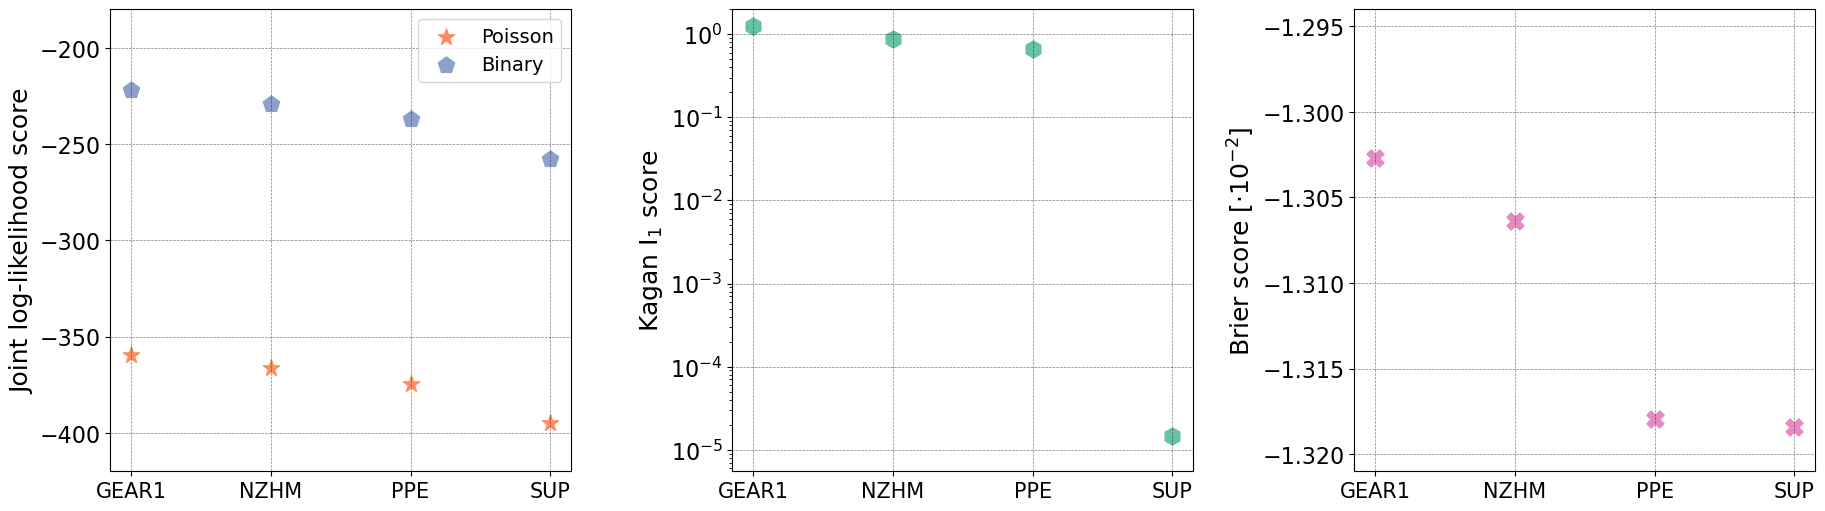

In [192]:
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(22,6))
models = np.array(['GEAR1', 'NZHM', 'PPE', 'SUP'])
x_pos = np.arange(len(models))

ax_jolips = fig.add_subplot(1,3,1)
ax_jolips.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5, zorder=0)
plt.yticks(fontsize=16)
jolips = np.array([LLP_GEAR1, LLP_NZHM, LLP_PPE, LLP_SUP])
jolibs = np.array([LLB_GEAR1, LLB_NZHM, LLB_PPE, LLB_SUP])
ax_jolips.scatter(x_pos,jolips,label='Poisson', color= '#fc8d62', marker="*", s=150, zorder=1)
ax_jolips.scatter(x_pos, jolibs, label='Binary', color='#8da0cb', marker="p", s=150, zorder=1)
ax_jolips.set_xticks(x_pos, labels=models, fontsize=15)
ax_jolips.set_ylim(-420,-180)
ax_jolips.set_ylabel('Joint log-likelihood score', fontsize=18)
ax_jolips.legend(fontsize=14)

ax_Kagans = fig.add_subplot(1,3,2)
ax_Kagans.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5, zorder=0)
plt.yticks(fontsize=16)
KaganI1s = np.array([KaganI1_GEAR1[0], KaganI1_NZHM[0], KaganI1_PPE[0], KaganI1_SUP[0]])
ax_Kagans.scatter(x_pos, KaganI1s, label='Kagan I$_{1}$', color='#66c2a5', marker="h", s=150, zorder=1)
ax_Kagans.set_xticks(x_pos, labels=models, fontsize=15)
ax_Kagans.set_ylabel('Kagan I$_{1}$ score', fontsize=18)
ax_Kagans.set_yscale("log")
ax_Kagans.set_ylim(5.5e-06, 2)

ax_Briers = fig.add_subplot(1,3,3)
ax_Briers.grid(linestyle='--', linewidth=0.5, color='k', alpha=0.5, zorder=0)
plt.yticks(fontsize=16)
Briers = np.array([Brier_GEAR1 *1e2, Brier_NZHM *1e2, Brier_PPE * 1e2, Brier_SUP * 1e2])
ax_Briers.scatter(x_pos, Briers, label= 'Brier', color= '#e78ac3', marker="X", s=150, zorder=1)
ax_Briers.set_xticks(x_pos, labels=models, fontsize=15)
ax_Briers.set_ylabel('Brier score [$\cdot$10$^{-2}$]', fontsize=18)
ax_Briers.set_ylim(-1.321, -1.294)
plt.subplots_adjust(wspace=0.35)
plt.savefig('../output/figure5.png', dpi=200, bbox_inches = 'tight')

### Roc and Molchan (from alarm-based contingency table) 

In [193]:
import pandas as pandas
from scipy.integrate import cumtrapz

def plot_contingency_ROC(forecast, catalog, axes=None, plot_uniform=True, savepdf=True, savepng=True, show=True,
                    plot_args=None):
    """
    Plot Receiver operating characteristic (ROC) based on forecast and test catalogs using the contingency table.
    The ROC is computed following this procedure:
        (1) Obtain spatial rates from GriddedForecast and the observed events from the observed catalog.
        (2) Rank the rates in descending order (highest rates first).
        (3) Sort forecasted rates by ordering found in (2), and normalize rates so their sum is equals unity.
        (4) Obtain binned spatial rates from observed catalog
        (5) Sort gridded observed rates by ordering found in (2).
        (6) Test each ordered and normalized forecasted rate defined in (3) as a threshold value to obtain the
            corresponding contingency table.
        (7) Define the H (Success rate) and F (False alarm rate) for each threshold soil using the information provided
            by the correspondent contingency table defined in (6).

    Note that:
        (1) The testing catalog and forecast should have exactly the same time-window (duration)
        (2) Forecasts should be defined over the same region
        (3) If calling this function multiple times, update the color in plot_args

    Args:
        forecast (:class: `csep.forecast.GriddedForecast`):
        catalog (:class:`AbstractBaseCatalog`): evaluation catalog
        axes (:class:`matplotlib.pyplot.ax`): Previously defined ax object
        savepdf (str):    output option of pdf file
        savepng (str):    output option of png file
        plot_uniform (bool): if true, include uniform forecast on plot

        Optional plotting arguments:
            * figsize: (:class:`list`/:class:`tuple`) - default: [9, 8]
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * forecast_linestyle: (:class:`str`) - default: '-'
            * observed_linecolor: (:class:`str`) - default: 'blue'
            * observed_linestyle: (:class:`str`) - default: '-'
            * forecast_label: (:class:`str`) - default: Observed (Forecast)
            * legend_fontsize: (:class:`float`) Fontsize of the plot title - default: 16
            * legend_loc: (:class:`str`) - default: 'upper left'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * label_fontsize: (:class:`float`) Fontsize of the plot title - default: 14
            * title: (:class:`str`) - default: 'ROC Curve'
            * filename: (:class:`str`) - default: roc_curve.

    Returns:
        :class:`matplotlib.pyplot.ax` object

    Raises:
        TypeError: throws error if CatalogForecast-like object is provided
        RuntimeError: throws error if Catalog and Forecast do not have the same region

        Written by Emanuele Biondini, UNIBO, March 2023.
    """


    # Parse plotting arguments
    plot_args = plot_args or {}
    figsize = plot_args.get('figsize', (9, 8))
    forecast_linestyle = plot_args.get('forecast_linestyle', '-')
    observed_linecolor = plot_args.get('observed_linecolor', '#e41a1c')
    observed_linestyle = plot_args.get('observed_linestyle', '-')
    legend_fontsize = plot_args.get('legend_fontsize', 16)
    legend_loc = plot_args.get('legend_loc', 'upper left')
    title_fontsize = plot_args.get('title_fontsize', 16)
    label_fontsize = plot_args.get('label_fontsize', 18)
    filename = plot_args.get('filename', 'roc_figure')
    title = plot_args.get('title', '')




    # Initialize figure
    if axes is not None:
        ax = axes
    else:
        fig, ax = plt.subplots(figsize=figsize)

    for i in range(len(forecast)):

        name = forecast[i].name
        if not name:
            name = ''
        else:
            name = f'{name}'

        forecast_label = plot_args.get('forecast_label', f'{name}')
        observed_label = plot_args.get('observed_label', f'{name}')
        if forecast[i].name == 'GEAR1' or forecast[i].name == 'NZHM':

            obs_counts = catalog[0].spatial_counts()


        else:
            obs_counts = catalog[1].spatial_counts()


        # Obtain forecast rates (or counts) and observed catalog aggregated in spatial cells
        rate = forecast[i].spatial_counts()
        # obs_counts = catalog.spatial_counts()
        # Define the threshold to be analysed to draw the Molchan diagram

        # Get index of rates (descending sort)
        I = numpy.argsort(rate)
        I = numpy.flip(I)

        # Order forecast and cells rates by highest rate cells first and normalize the rates.
        thresholds = (rate[I]) / numpy.sum(rate)
        obs_counts = obs_counts[I]

        Table_ROC = pandas.DataFrame({
            'Threshold': [],
            'Successful_bins': [],
            'Obs_active_bins': [],
            'H': [],
            'F': []

        })

        #Each forecasted and normalized rate are tested as a threshold value to define the contingency table.
        for threshold in thresholds:
            threshold = float(threshold)

            binary_forecast = numpy.where(thresholds >= threshold, 1, 0)
            forecastedYes_observedYes = obs_counts[(binary_forecast == 1) & (obs_counts > 0)]
            forecastedYes_observedNo=obs_counts[(binary_forecast == 1) & (obs_counts == 0)]
            forecastedNo_observedYes=obs_counts[(binary_forecast == 0) & (obs_counts > 0)]
            forecastedNo_observedNo = obs_counts[(binary_forecast == 0) & (obs_counts == 0)]
            # Creating the DataFrame for the contingency table
            data = {
                "Observed": [len(forecastedYes_observedYes), len(forecastedNo_observedYes)],
                "Not Observed": [len(forecastedYes_observedNo), len(forecastedNo_observedNo)]
            }
            index = ["Forecasted", "Not Forecasted"]
            contingency_df = pandas.DataFrame(data, index=index)

            H = contingency_df.loc['Forecasted', 'Observed'] / (
                        contingency_df.loc['Forecasted', 'Observed'] + contingency_df.loc['Not Forecasted', 'Observed'])
            F = contingency_df.loc['Forecasted', 'Not Observed'] / (
                        contingency_df.loc['Forecasted', 'Not Observed'] + contingency_df.loc[
                    'Not Forecasted', 'Not Observed'])

            threshold_row = {
                'Threshold': threshold,
                'Successful_bins': contingency_df.loc['Forecasted', 'Observed'],
                'Obs_active_bins': contingency_df['Observed'].sum(),
                'H': H,
                'F': F

            }
            threshold_row_df = pandas.DataFrame([threshold_row])

            # Concatena threshold_row_df a Table_molchan
            Table_ROC = pandas.concat([Table_ROC, threshold_row_df], ignore_index=True)




        forecast_linecolor = ['#377eb8', '#4daf4a', '#984ea3']
        # Plot sorted and normalized forecast (descending order)
        ax.plot(Table_ROC['F'], Table_ROC['H'],
                label=forecast_label,
                color=forecast_linecolor[i],
                linestyle = forecast_linestyle)

    # Plot cell-wise rates of observed catalog ordered by forecast rates (descending order)
    # ax.step(area_norm_sorted, obs_norm_sorted,
    #         label=observed_label,
    #         color=observed_linecolor,
    #         linestyle = observed_linestyle)
    # Plot uniform forecast
    if plot_uniform:
        x_uniform = numpy.arange(0, 1.001, 0.001)
        y_uniform = numpy.arange(0, 1.001, 0.001)
        ax.plot(x_uniform, y_uniform, '#ff7f00', label='SUP')
    # Plotting arguments
    ax.set_ylabel("Hit Rate", fontsize=label_fontsize)
    ax.set_xlabel('Fraction of false alarms', fontsize=label_fontsize)
    ax.set_xlim([1e-4, 1.5])
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.tick_params(axis='x', labelsize=label_fontsize)
    ax.tick_params(axis='y', labelsize=label_fontsize)
    ax.legend(loc=legend_loc, shadow=True, fontsize=legend_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.text(1e-4, 1.1, 'a)', fontsize=28, color='black')

    if filename:
        if savepdf:
            outFile = "{}.pdf".format(filename)
            plt.savefig(outFile, format='pdf')
        if savepng:
            outFile = "{}.png".format(filename)
            plt.savefig(outFile,format='png')

    if show:
        plt.show()
    return ax



def plot_contingency_Molchan(forecast, catalog, axes=None, plot_uniform=True, savepdf=True, savepng=True, show=True,
                    plot_args=None):
    """
    Plot the Molchan Diagram based on forecast and test catalogs using the contingency table.

    The Molchan diagram is computed following this procedure:
        (1) Obtain spatial rates from GriddedForecast and the observed events from the observed catalog.
        (2) Rank the rates in descending order (highest rates first).
        (3) Sort forecasted rates by ordering found in (2), and normalize rates so their sum is equals unity.
        (4) Obtain binned spatial rates from observed catalog
        (5) Sort gridded observed rates by ordering found in (2).
        (6) Test each ordered and normalized forecasted rate defined in (3) as a threshold value to obtain the
            corresponding contingency table.
        (7) Define the "nu" (Miss rate) and "tau" (Fraction of spatial alarmed cells) for each threshold soil using the
            information provided by the correspondent contingency table defined in (6).


    Note that:
        (1) The testing catalog and forecast should have exactly the same time-window (duration)
        (2) Forecasts should be defined over the same region
        (3) If calling this function multiple times, update the color in plot_args

    Args:
        forecast (:class: `csep.forecast.GriddedForecast`):
        catalog (:class:`AbstractBaseCatalog`): evaluation catalog
        axes (:class:`matplotlib.pyplot.ax`): Previously defined ax object
        savepdf (str):    output option of pdf file
        savepng (str):    output option of png file
        plot_uniform (bool): if true, include uniform forecast on plot

        Optional plotting arguments:
            * figsize: (:class:`list`/:class:`tuple`) - default: [9, 8]
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * forecast_linecolor: (:class:`str`) - default: 'black'
            * forecast_linestyle: (:class:`str`) - default: '-'
            * forecast_label: (:class:`str`) - default: Observed (Forecast)
            * legend_fontsize: (:class:`float`) Fontsize of the plot title - default: 16
            * legend_loc: (:class:`str`) - default: 'upper left'
            * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 18
            * label_fontsize: (:class:`float`) Fontsize of the plot title - default: 14
            * title: (:class:`str`) - default: 'Molchan diagram'
            * filename: (:class:`str`) - default: molchan_diagram.

    Returns:
        :class:`matplotlib.pyplot.ax` object

    Raises:
        TypeError: throws error if CatalogForecast-like object is provided
        RuntimeError: throws error if Catalog and Forecast do not have the same region

       Written by Emanuele Biondini, UNIBO, March 2023.
    """
    # if not catalog.region == forecast.region:
    #     raise RuntimeError("catalog region and forecast region must be identical.")

    # Parse plotting arguments
    plot_args = plot_args or {}
    figsize = plot_args.get('figsize', (9, 8))
    # forecast_linecolor = plot_args.get('forecast_linecolor', ['red', 'gold', 'purple'])
    forecast_linestyle = plot_args.get('forecast_linestyle', '-')
    observed_linecolor = plot_args.get('observed_linecolor', '#e41a1c')
    observed_linestyle = plot_args.get('observed_linestyle', '-')
    legend_fontsize = plot_args.get('legend_fontsize', 16)
    legend_loc = plot_args.get('legend_loc', 'lower left')
    title_fontsize = plot_args.get('title_fontsize', 16)
    label_fontsize = plot_args.get('label_fontsize', 18)
    filename = plot_args.get('filename', 'molchan_figure')
    title = plot_args.get('title', '')


    # Initialize figure
    if axes is not None:
        ax = axes
    else:
        fig, ax = plt.subplots(figsize=figsize)

    for i in range(len(forecast)):
        name = forecast[i].name
        if not name:
            name = ''
        else:
            name = f'{name}'

        forecast_label = plot_args.get('forecast_label', f'{name}')
        observed_label = plot_args.get('observed_label', f'{name}')
        if forecast[i].name == 'GEAR1' or forecast[i].name == 'NZHM':
            obs_counts = catalog[0].spatial_counts()
        else:
            obs_counts = catalog[1].spatial_counts()
        # Obtain rates (or counts) aggregated in spatial cells
        # If CatalogForecast, needs expected rates. Might take some time to compute.
        rate = forecast[i].spatial_counts()
        # obs_counts = catalog[i].spatial_counts()
        # Define the threshold to be analysed tp draw the Molchan diagram

        # Get index of rates (descending sort)
        I = numpy.argsort(rate)
        I = numpy.flip(I)

        # Order forecast and cells rates by highest rate cells first
        thresholds = (rate[I]) / numpy.sum(rate)
        obs_counts = obs_counts[I]

        Table_molchan = pandas.DataFrame({
            'Threshold': [],
            'Successful_bins': [],
            'Obs_active_bins': [],
            'tau': [],
            'nu': [],
            'R_score': []
        })
        for threshold in thresholds:
            # print(threshold)
            threshold = float(threshold)

            binary_forecast = numpy.where(thresholds >= threshold, 1, 0)
            forecastedYes_observedYes = obs_counts[(binary_forecast == 1) & (obs_counts > 0)]
            forecastedYes_observedNo=obs_counts[(binary_forecast == 1) & (obs_counts == 0)]
            forecastedNo_observedYes=obs_counts[(binary_forecast == 0) & (obs_counts > 0)]
            forecastedNo_observedNo = obs_counts[(binary_forecast == 0) & (obs_counts == 0)]
            # Creating the DataFrame for the contingency table
            data = {
                "Observed": [len(forecastedYes_observedYes), len(forecastedNo_observedYes)],
                "Not Observed": [len(forecastedYes_observedNo), len(forecastedNo_observedNo)]
            }
            index = ["Forecasted", "Not Forecasted"]
            contingency_df = pandas.DataFrame(data, index=index)
            nu = contingency_df.loc['Not Forecasted', 'Observed'] / contingency_df['Observed'].sum()
            tau = contingency_df.loc['Forecasted'].sum() / (contingency_df.loc['Forecasted'].sum() +
                                                            contingency_df.loc['Not Forecasted'].sum())
            R_score = (contingency_df.loc['Forecasted', 'Observed'] / contingency_df['Observed'].sum()) - \
                      (contingency_df.loc['Forecasted', 'Not Observed'] / contingency_df['Not Observed'].sum())

            threshold_row = {
                'Threshold': threshold,
                'Successful_bins': contingency_df.loc['Forecasted', 'Observed'],
                'Obs_active_bins': contingency_df['Observed'].sum(),
                'tau': tau,
                'nu': nu,
                'R_score': R_score,

            }
            threshold_row_df = pandas.DataFrame([threshold_row])

            # Concatena threshold_row_df a Table_molchan
            Table_molchan = pandas.concat([Table_molchan, threshold_row_df], ignore_index=True)

        bottom_row = {'Threshold': 'Full alarms', 'tau': 1, 'nu': 0, 'Obs_active_bins': contingency_df['Observed'].sum()}
        top_row = {'Threshold': 'No alarms', 'tau': 0, 'nu': 1, 'Obs_active_bins': contingency_df['Observed'].sum()}
        # Aggiunta della riga sopra
        Table_molchan = pandas.concat([pd.DataFrame([top_row]), Table_molchan], ignore_index=True)
        # Aggiunta della riga sotto
        Table_molchan = pandas.concat([Table_molchan, pd.DataFrame([bottom_row])], ignore_index=True)

        Tab_as_score = pd.DataFrame()

        Tab_as_score['Threshold'] = Table_molchan['Threshold']
        Tab_as_score['tau'] = Table_molchan['tau']
        Tab_as_score['nu'] = Table_molchan['nu']

        # # Creazione delle nuove righe da aggiungere sopra e sotto
        # bottom_row = {'Threshold': 'Full alarms', 'tau': 1, 'nu': 0}
        # top_row = {'Threshold': 'No alarms', 'tau': 0, 'nu': 1}
        # # Aggiunta della riga sopra
        # Tab_as_score = pd.DataFrame([top_row]).append(Tab_as_score, ignore_index=True)
        #
        # # Aggiunta della riga sotto
        # Tab_as_score = Tab_as_score.append([bottom_row], ignore_index=True)

        ONE = np.ones(len(Tab_as_score))
        Tab_as_score['CUM_BAND'] = cumtrapz(ONE, Tab_as_score['tau'], initial=0) - cumtrapz(Tab_as_score['nu'],
                                                                                            Tab_as_score['tau'],
                                                                                            initial=0)
        Tab_as_score['AS_score'] = np.divide(Tab_as_score['CUM_BAND'],
                                             cumtrapz(ONE, Tab_as_score['tau'], initial=0) + 1e-10)
        Tab_as_score.loc[Tab_as_score.index[-1], 'AS_score'] = max(0.5, Tab_as_score['AS_score'].iloc[-1])
        ASscore=np.round(Tab_as_score.loc[Tab_as_score.index[-1], 'AS_score'],2)

        bin = 0.01
        import math
        devstd = np.sqrt(1 / (12 * Table_molchan['Obs_active_bins'].iloc[0]))
        devstd = devstd * bin ** -1
        devstd = math.ceil(devstd + 0.5)
        devstd = devstd / bin ** -1
        Tab_as_score['st_dev'] = devstd
        Tab_as_score['st_dev'] = devstd
        dev_std=np.round(devstd,2)

        # Plot sorted and normalized forecast (descending order)
        forecast_linecolor = ['#377eb8', '#4daf4a', '#984ea3']
        ax.plot(Table_molchan['tau'], Table_molchan['nu'],
                label= f"{forecast_label}, AS={ASscore}±{dev_std} ",
                color=forecast_linecolor[i],
                linestyle=forecast_linestyle)

    # Plot cell-wise rates of observed catalog ordered by forecast rates (descending order)
    # ax.step(area_norm_sorted, obs_norm_sorted,
    #         label=observed_label,
    #         color=observed_linecolor,
    #         linestyle = observed_linestyle)
        # Plot uniform forecast
    if plot_uniform:
        x_uniform = numpy.arange(0, 1.001, 0.001)
        y_uniform = numpy.arange(1.00, -0.001, -0.001)
        ax.plot(x_uniform, y_uniform, '#ff7f00', label='SUP'+' AS=0.50')
    # Plotting arguments
    ax.set_ylabel("Miss Rate", fontsize=label_fontsize)
    ax.set_xlabel('Fraction of area occupied by alarms', fontsize=label_fontsize)
    ax.set_xlim([1e-4,1.5])
    ax.set_xscale('log')
    ax.tick_params(axis='x', labelsize=label_fontsize)
    ax.tick_params(axis='y', labelsize=label_fontsize)
    ax.legend(loc=legend_loc, shadow=True, fontsize=legend_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.text(1e-4, 1.1, 'c)', fontsize=28, color='black')

    if filename:
        if savepdf:
            outFile = "{}.pdf".format(filename)
            plt.savefig(outFile, format='pdf')
        if savepng:
            outFile = "{}.png".format(filename)
            plt.savefig(outFile,format='png')

    if show:
        plt.show()
    return ax

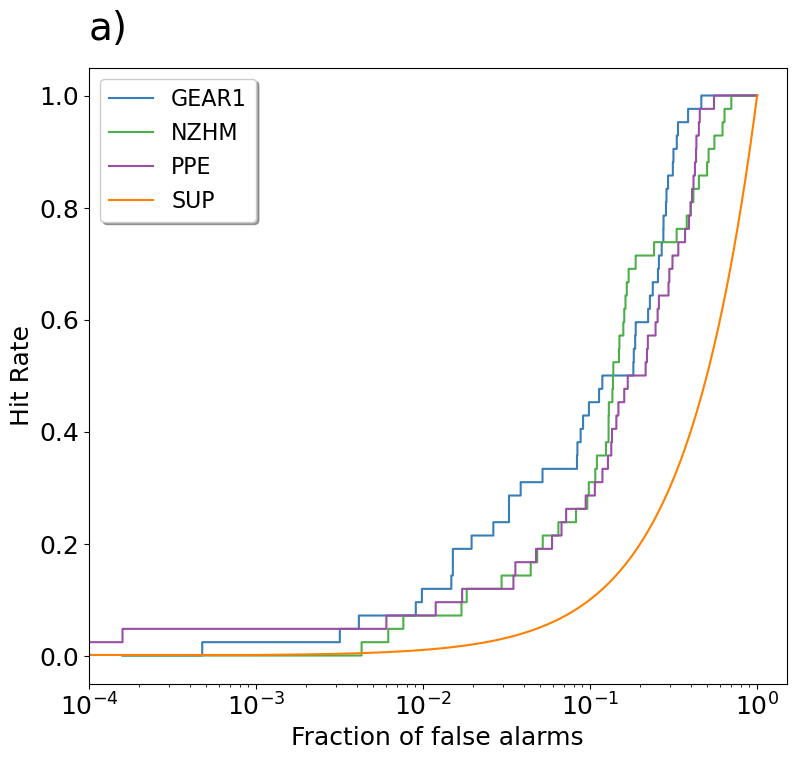

In [196]:
args_dict = {
             'bbox_inches' : 'tight',
             'tight_layout': True,
             'filename' : "../output/figure6a"
            }


ax1=plot_contingency_ROC([GEAR1NZ_f, NZHM_f, PPE_f], [catalogue_NZ, catalogue_NZP], axes=None, plot_uniform=True,
             savepdf=False,
             savepng=True, show=True,
             plot_args=args_dict)
# plt.savefig('../output/contingeny_roc_curves.png', dpi=150, bbox_inches = 'tight')


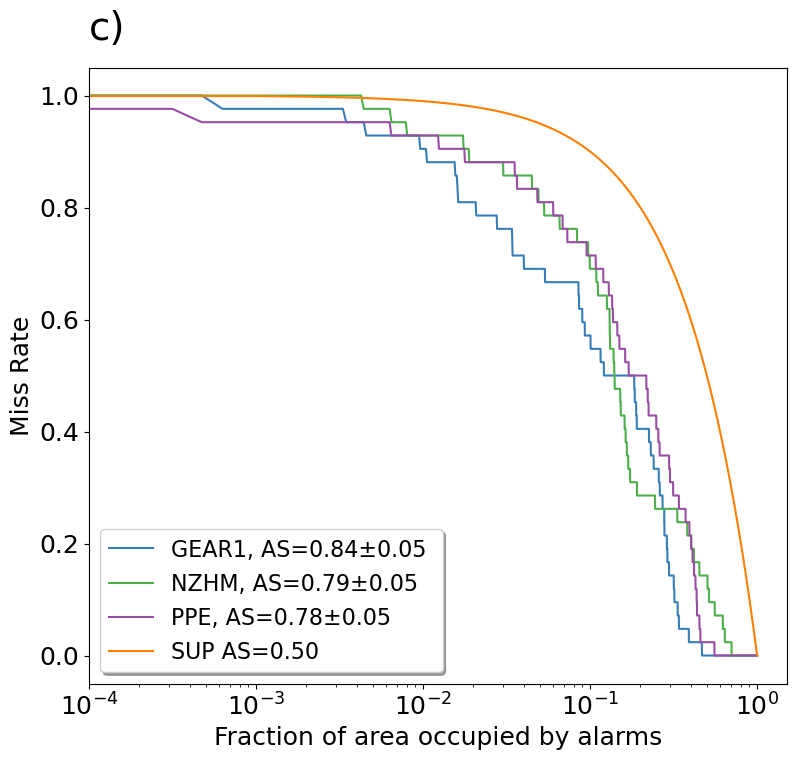

In [197]:
args_dict = {
             'bbox_inches' : 'tight',
             'tight_layout': True,
             'filename' : "../output/figure6c"
            }


ax2=plot_contingency_Molchan([GEAR1NZ_f, NZHM_f, PPE_f], [catalogue_NZ, catalogue_NZP], axes=None, plot_uniform=True,
             savepdf=False,
             savepng=True, show=True,
             plot_args=args_dict)
# plt.savefig('../output/contingency_molchan_curves.png', dpi=150, bbox_inches = 'tight')